vision encoder : full tuning  
aligner : full tuning  
llm : freezed  

In [ ]:
!pip install -q -U datasets einops transformers autoawq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   

In [ ]:
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, CLIPTextModel, CLIPVisionModel
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Configs

In [ ]:
IMAGE_SIZE = (224, 224)
N_PATCHES_PER_IMAGE = 50#(IMAGE_SIZE[0] // vision_encoder.config.patch_size) * (IMAGE_SIZE[1] // vision_encoder.config.patch_size)
# N_COMPRESSED_PATCHES_PER_IMAGE = 10
N_COMPRESSED_PATCHES_PER_IMAGE = 50

IMAGE_TOKEN = '<|imagetoken|>'
BOI_TOKEN = '<|boi|>'  # begining of image token
EOI_TOKEN = '<|eoi|>'  # end of image token
# CLS_TOKEN = '<|cls|>'

TEXT_PADDING_MAX_LENGTH = 80 + 150 + N_COMPRESSED_PATCHES_PER_IMAGE

N_EPOCHS = 40
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 8#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = True
AMP_DTYPE = torch.bfloat16

dtype = torch.float32#torch.bfloat16
llm_dtype = torch.bfloat16

TRAIN_VISION_ENCODER = True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load LLM Model and Tokenizer

In [ ]:
if device == 'cuda':
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ")
    llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ", torch_dtype=llm_dtype).to(device).eval()
else:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
    llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype=llm_dtype).to(device).eval()

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
_ = llm_model.requires_grad_(False)

In [ ]:
tokenizer.add_tokens([IMAGE_TOKEN, BOI_TOKEN, EOI_TOKEN], special_tokens=True)

3

In [ ]:
IMAGE_TOKEN_ID = tokenizer.convert_tokens_to_ids(IMAGE_TOKEN)

In [ ]:
tokenizer

Qwen2TokenizerFast(name_or_path='Qwen/Qwen2.5-0.5B-Instruct-AWQ', vocab_size=151643, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', '<|box_end|>', '<|quad_start|>', '<|quad_end|>', '<|vision_start|>', '<|vision_end|>', '<|vision_pad|>', '<|image_pad|>', '<|video_pad|>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=Fa

## Load Vision Encoder Model

In [ ]:
vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device).eval()

In [ ]:
_ = vision_encoder.requires_grad_(False)

## Prepare Dataset

In [ ]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list], cache_dir='./cache_data')['train']

In [ ]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [ ]:
hf_dataset_sampled

Dataset({
    features: ['__key__', '__url__', 'jpg', 'json'],
    num_rows: 1000
})

In [ ]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMAGE_SIZE, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
# tokenizer.encode('<|im_start|>assistant')

In [ ]:
torch.tensor([False, False, False, True, False, False, True, False]).long().argmax()

tensor(3)

In [ ]:
@torch.inference_mode()
def tokenize_text(texts, tokenizer=tokenizer, ignore_label = -100):
    non_prediction_target_text = f'<|vision_start|>{N_COMPRESSED_PATCHES_PER_IMAGE * IMAGE_TOKEN}<|vision_end|> describe the text'
    # end_of_non_prediction_target_token = tokenizer.encode(non_prediction_target_text)[-1]
    end_of_non_prediction_target_token = tokenizer.encode('<|im_start|>assistant')[-1]
    conversation_text_list = []
    for text in texts:
        conversations = [
            {'content': non_prediction_target_text, 'role': 'user'},
            {'content': text, 'role': 'assistant'},
        ]
        conversation_text = tokenizer.apply_chat_template(
            conversations, tokenize=False
        )
        conversation_text_list.append(conversation_text)

    inputs = tokenizer(conversation_text_list, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    inputs['loss_target_pos_mask'] = torch.zeros_like(inputs['input_ids'])
    loss_target_start_idx = (inputs['input_ids'] == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1
    # print(loss_target_start_idx)
    assert (loss_target_start_idx == loss_target_start_idx[0]).all()
    loss_target_start_idx = loss_target_start_idx[0]
    inputs['loss_target_pos_mask'][torch.arange(inputs['loss_target_pos_mask'].shape[0]), loss_target_start_idx:] = 1
    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs

def preprocess_data(examples, vision_encoder=vision_encoder):
    # print('preprocess_data')
    images = [image.convert("RGB") for image in examples['jpg']]
    images = [image_transforms(image) for image in images]
    image_embs = vision_encoder(torch.stack(images).to(device)).last_hidden_state

    examples["pixel_values"] = images
    examples["image_embs"] = image_embs
    tokenized_inputs = tokenize_text([d['prompt'] for d in examples['json']])
    examples["input_ids"] = tokenized_inputs['input_ids']
    examples["attention_mask"] = tokenized_inputs['attention_mask']
    examples["loss_target_pos_mask"] = tokenized_inputs['loss_target_pos_mask']

    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    image_embs = torch.stack([example["image_embs"] for example in examples])
    input_ids = torch.stack([example["input_ids"] for example in examples])
    attention_mask = torch.stack([example["attention_mask"] for example in examples])
    loss_target_pos_mask = torch.stack([example["loss_target_pos_mask"] for example in examples])

    return {
        "pixel_values": pixel_values,
        'image_embs': image_embs,
        "input_ids": input_ids,
        'attention_mask': attention_mask,
        'loss_target_pos_mask': loss_target_pos_mask,
    }

In [ ]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 2.45 s, sys: 817 ms, total: 3.27 s
Wall time: 3.9 s


In [ ]:
_d = hf_dataset_sampled[0]

In [ ]:
_d.keys()

dict_keys(['__key__', '__url__', 'jpg', 'json', 'pixel_values', 'image_embs', 'input_ids', 'attention_mask', 'loss_target_pos_mask'])

In [ ]:
tokenizer.decode(_d['input_ids'])

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|boi|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|imagetoken|><|eoi|> describe the text<|im_end|>\n<|im_start|>assistant\nA group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shi

In [ ]:
tokenizer.decode(_d['input_ids'] * _d['loss_target_pos_mask'])

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.<|im_end|>\n<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

In [ ]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

In [ ]:
_batch = next(iter(train_dataloader))

tensor([83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83,
        83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83,
        83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83,
        83, 83, 83, 83, 83, 83, 83, 83, 83, 83])


In [ ]:
# tokenizer.batch_decode(_batch['input_ids'] * _batch['loss_target_pos_mask'])

## Image Text Interleaved Embedding Utils

In [ ]:
def convert_to_text_vision_interleaved_emb(
    input_ids: torch.LongTensor,
    attention_mask: torch.LongTensor,
    llm_model: torch.nn.Module,
    vision_encoder: torch.nn.Module,
    pre_calc_image_emb: torch.FloatTensor = None,
    vision_emb_compresser: torch.nn.Module = None,
    text_emb_projector: torch.nn.Module = None,
    images: torch.FloatTensor = [],
    image_token_id: int = IMAGE_TOKEN_ID,
    debug: bool = False,
    validate_image_emb: bool = True,
):
    """
    input_ids: (bs, max_seq_len)
    attention_mask: (bs, max_seq_len)
    pre_calc_image_emb: (n_images, n_image_tokens_per_image, image_emb_dim)
    """
    if validate_image_emb:
        _image_emb = llm_model.model.embed_tokens(torch.tensor([IMAGE_TOKEN_ID]).long().to(input_ids.device))   # (1, text_emb_dim)
        # _image_emb = llm_model.embed_tokens(torch.tensor([151644]).long())   # (1, text_emb_dim)
    text_embed = llm_model.model.embed_tokens(input_ids)  # (bs, max_seq_len) => (bs, max_seq_len, text_emb_dim)
    if text_emb_projector is not None:
        text_embed = text_emb_projector(text_embed)  # (bs, max_seq_len, text_emb_dim) => (bs, max_seq_len, text_emb_dim)
    if pre_calc_image_emb is not None:
        vision_embed = pre_calc_image_emb  # (n_images, n_image_token, image_emb_dim)
    else:
        vision_embed = vision_encoder(images).last_hidden_state  # (n_images, ch, h, w) => (n_images, n_image_token, image_emb_dim)
    if vision_emb_compresser is not None:
        vision_embed = vision_emb_compresser(vision_embed)  # (n_images, n_image_token, image_emb_dim) => (n_images, n_image_token_compressed, image_emb_dim)
    n_images, n_image_token_compressed_per_image, emb_dim = vision_embed.shape
    assert (input_ids == image_token_id).sum() == (n_images * n_image_token_compressed_per_image)
    assert text_embed.shape[-1] == vision_embed.shape[-1]  # text_emb_dim == image_emb_dim
    bs = input_ids.shape[0]

    vision_embed = einops.rearrange(vision_embed, 'ni nt d -> (ni nt) d')  # -> (n_images x n_image_token_compressed_per_image, emb_dim)
    text_embed = einops.rearrange(text_embed, 'bs sl d -> (bs sl) d')  # -> (bs x max_seq_len, emb_dim)
    image_token_pos_mask = input_ids == image_token_id  # (bs, max_seq_len)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, 'bs sl -> (bs sl)')  # -> (bs x max_seq_len,)
    assert vision_embed.shape[0] == image_token_pos_mask.sum()
    # print(text_embed.requires_grad, vision_embed.requires_grad)
    text_embed[image_token_pos_mask] = vision_embed.to(text_embed.dtype)   # (bs x max_seq_len, emb_dim)
    text_vision_emb = einops.rearrange(text_embed, '(bs sl) d -> bs sl d', bs=bs)  # -> (bs, max_seq_len, emb_dim)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, '(bs sl) -> bs sl', bs=bs)  # -> (bs, max_seq_len)
    # print(text_vision_emb.requires_grad)

    text_vision_mask = attention_mask

    if validate_image_emb:
        # ensure placeholder image token emb is replaced by actual image emb of vision encoder output
        assert not (text_vision_emb == _image_emb.repeat(text_vision_emb.shape[0], text_vision_emb.shape[1], 1)).all(dim=-1).any()
    return text_vision_emb, text_vision_mask, image_token_pos_mask


## Model

In [ ]:
def positionalencoding1d(d_model, length, dtype=dtype):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(dtype)

### Projector

In [ ]:
class TextEmbProjectorMLP(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, out_dim=None, dropout=0.05, bias=True):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self._head = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(intermediate_dim, out_dim, bias=bias),
        )

    def forward(self, x):
        return self._head(x)

### Image Emb Compressor

In [ ]:
class ImageEmbCompressorCrossAttn(nn.Module):
    def __init__(
        self,
        in_dim: int,
        compressed_n_tokens: int,
        hidden_size: int = None,
        out_dim: int = None,
        dropout: float = 0.05,
        num_heads: int = 8,
        n_max_tokens: int = N_PATCHES_PER_IMAGE,
    ):
        super().__init__()
        if hidden_size is None:
            hidden_size = in_dim
        self.query_compressed_tokens = nn.Parameter(torch.rand(1, compressed_n_tokens, hidden_size))  # lernable query for compressed tokens
        self.x_proj = nn.Linear(in_dim, hidden_size)
        self.out_proj = nn.Linear(hidden_size, out_dim) if out_dim is not None and out_dim != hidden_size else nn.Identity
        self.act = nn.GELU()
        self.dropout = dropout
        self.norm = nn.LayerNorm(hidden_size)
        self.x_pe = positionalencoding1d(hidden_size, N_PATCHES_PER_IMAGE).unsqueeze(0)
        self.num_heads = num_heads

    def forward(self, x):
        """
        x: (bs, n_patches(n_tokens), patch_emb_dim)
        """
        # 1. input projection
        x_proj = self.act(self.norm(self.x_proj(x)))  # (bs, n_tokens, patch_emb_dim) => (bs, n_tokens, hidden_size)
        if self.x_pe is not None:
            x_proj = x_proj + self.x_pe[:, :x_proj.shape[1], :x_proj.shape[2]].to(x.device).to(x_proj.dtype)

        # 2. compression by cross attention
        hidden_size = x_proj.shape[-1]
        x_proj = einops.rearrange(x_proj, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, num_heads, n_tokens, hidden_size_head)
        query_compressed_tokens = einops.rearrange(self.query_compressed_tokens, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)
        compressed = F.scaled_dot_product_attention(
            query=query_compressed_tokens.to(x_proj.device).to(x_proj.dtype), key=x_proj, value=x_proj,
            dropout_p=self.dropout, is_causal=False
        )  # (bs, num_heads, compressed_n_tokens, hidden_size)
        compressed = einops.rearrange(compressed, 'b nh sl d -> b sl (nh d)', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, compressed_n_tokens, hidden_size)

        # 3. output projection
        compressed = self.act(self.norm(compressed))  # (bs, compressed_n_tokens, hidden_size)
        compressed = self.out_proj(compressed)  # (bs, compressed_n_tokens, out_dim)
        return compressed

In [ ]:
# text_emb_projector = TextEmbProjectorMLP(
#     in_dim=llm_model.config.hidden_size,
#     intermediate_dim=1024,
#     out_dim=llm_model.config.hidden_size,
# ).to(dtype).to(device)
text_emb_projector = None

image_emb_compressor = ImageEmbCompressorCrossAttn(
    in_dim=vision_encoder.config.hidden_size,
    compressed_n_tokens=N_COMPRESSED_PATCHES_PER_IMAGE,
    hidden_size=1024,
    out_dim=llm_model.config.hidden_size,
    dropout=0.0,
    num_heads=8,
).to(dtype).to(device)
# image_emb_compressor = nn.Sequential(
#     nn.Linear(vision_encoder.config.hidden_size, llm_model.config.hidden_size),
#     nn.GELU(),
# ).to(dtype).to(device)

vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device)
llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ" if device == 'cuda' else "Qwen/Qwen2.5-0.5B-Instruct", torch_dtype=llm_dtype).to(device)

We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
llm_model = llm_model.eval().requires_grad_(False)

In [ ]:
torch.save(vision_encoder.state_dict(), 'init_vision_encoder.pt')
torch.save(image_emb_compressor.state_dict(), 'init_image_emb_compressor.pt')
torch.save(llm_model.state_dict(), 'init_llm_model.pt')

In [ ]:
# train_models = [text_emb_projector, image_emb_compressor]
train_models = [image_emb_compressor, vision_encoder]
# train_models = [image_emb_compressor, vision_encoder, llm_model]

In [ ]:
# _text_vison_emb, _text_vison_mask, _vision_pos_mask = convert_to_text_vision_interleaved_emb(
#     input_ids=_batch['input_ids'],
#     attention_mask=_batch['attention_mask'],
#     llm_model=llm_model,
#     vision_encoder=vision_encoder,
#     pre_calc_image_emb=_batch['image_embs'].to(dtype),
#     vision_emb_compresser=image_emb_compressor,
#     text_emb_projector=text_emb_projector,
#     images=[],
#     image_token_id=IMAGE_TOKEN_ID,
#     debug=False,
# )
# print(_text_vison_emb.shape, _text_vison_mask.shape, _vision_pos_mask.shape)

# _llm_out = llm_model(
#     attention_mask=_text_vison_mask,
#     inputs_embeds=_text_vison_emb,
# )
# print(_llm_out.last_hidden_state.shape)


In [ ]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [ ]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [ ]:
optimizer = torch.optim.AdamW(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device=device, enabled=USE_AMP)

In [ ]:
loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(N_EPOCHS):
    # Train phase
    [m.train() for m in train_models]
    epoch_loss = 0.0
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
        target_labels[batch['loss_target_pos_mask'][:, :-1] == 0] = -100
        optimizer.zero_grad()
        with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
            # 1.
            text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                llm_model=llm_model,
                vision_encoder=vision_encoder,
                pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                vision_emb_compresser=image_emb_compressor,
                text_emb_projector=text_emb_projector,
                images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                image_token_id=IMAGE_TOKEN_ID,
                debug=False,
            )
            # 2.
            llm_out = llm_model(
                attention_mask=text_vison_mask,
                inputs_embeds=text_vison_emb.to(llm_dtype),
            )
            pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
            assert pred_logits.shape[:2] == target_labels.shape
            loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
            if torch.isnan(loss):
                print('loss is nan')
                raise Exception()
            pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
            true_labels.append(target_labels.cpu().detach())
            metric_target_mask_list.append((batch['loss_target_pos_mask'] * batch['attention_mask'])[:, :-1].cpu())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        # loss.backward()
        # optimizer.step()
        scaler.update()
        scheduler.step()
        epoch_loss += loss.cpu().detach()
    pred_labels = torch.cat(pred_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    metric_target_mask = torch.cat(metric_target_mask_list, dim=0)
    # acc = (pred_labels.flatten() == true_labels.flatten()).float().mean()
    acc = ((pred_labels == true_labels).long() * metric_target_mask.cpu()).sum() / metric_target_mask.sum()
    train_acc_history.append(acc)
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}')

    gt_texts = tokenizer.batch_decode(true_labels[:3] * metric_target_mask[:3])
    pred_texts = tokenizer.batch_decode(pred_labels[:3] * metric_target_mask[:3])
    print('train gt txt', gt_texts)
    print('train pred txt', pred_texts)

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            target_labels = batch['input_ids'][:, 1:].clone()  # (bs, seq_len -1)
            target_labels[batch['loss_target_pos_mask'][:, :-1] == 0] = -100
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=USE_AMP):
                # 1.
                text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    llm_model=llm_model,
                    vision_encoder=vision_encoder,
                    pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                    vision_emb_compresser=image_emb_compressor,
                    text_emb_projector=text_emb_projector,
                    images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                    image_token_id=IMAGE_TOKEN_ID,
                    debug=False,
                )
                # 2.
                llm_out = llm_model(
                    attention_mask=text_vison_mask,
                    inputs_embeds=text_vison_emb.to(llm_dtype),
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len -1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((batch['loss_target_pos_mask'] * batch['attention_mask'])[:, :-1].cpu())
    pred_labels = torch.cat(pred_labels, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    metric_target_mask = torch.cat(metric_target_mask_list, dim=0)
    # acc = (pred_labels.flatten() == true_labels.flatten()).float().mean()
    acc = ((pred_labels == true_labels).long() * metric_target_mask.cpu()).sum() / metric_target_mask.sum()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}')

    gt_texts = tokenizer.batch_decode(true_labels[:3] * metric_target_mask[:3])
    pred_texts = tokenizer.batch_decode(pred_labels[:3] * metric_target_mask[:3])
    print('test gt txt', gt_texts)
    print('test pred txt', pred_texts)

    print(scheduler.get_lr())

epoch 0 : loss 12.745174407958984 : acc 0.4722232222557068
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pair of blue-handled wire cutters with black grips and a silver cutting mechanism is displayed against a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A serene beach scene with a clear blue sky, a calm sea, and a sandy shore. There are two thatched-roof huts on stilts near the water, and a wooden pier extends into the sea. Palm trees with lush green leaves are scattered along the beach, and there are several lounge chairs placed on the sand.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 0 : test acc 0.4831814467906952
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body i

epoch 1 : loss 12.743030548095703 : acc 0.4723857641220093
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black leather chair with a high backrest and armrests, featuring a tufted design on the seat cushion and backrest, and wooden legs.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A man with short white hair wearing a colorful Hawaiian shirt and glasses is smiling at the camera. He is surrounded by a crowd of people, some of whom are wearing glasses and ties. The man is standing in front of a red carpet, suggesting a formal event or red carpet event.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',

epoch 1 : test acc 0.48119303584098816
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 2 : loss 12.75291633605957 : acc 0.47207874059677124
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The cover of the book 'All Saints' by K.D. Miller, featuring an ornate red and black border with intricate designs and a central image of a cross.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern glass pendant light with a clear dome-shaped shade and a metallic finish hangs from a white ceiling. The light is turned on, casting a soft glow and creating a warm ambiance.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 2 : test acc 0.482850044965744
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body is

epoch 3 : loss 12.748438835144043 : acc 0.4723496437072754
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The first image shows the exterior of a hotel building with a prominent sign that reads 'CANDLEWOOD SUITES'. The building has a beige color with a white trim around the windows and doors. There are multiple windows on each floor, and the hotel appears to have a modern design. The roof is visible, and there are two air conditioning units on the ground near the building. The parking lot is empty, and there are no visible vehicles or people.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and green camouflage hoodie with a hood, front zip, and long sleeves. The hoodie is modeled on a mannequin, and the image is a close-up of the upper body. The camouflage pattern i

epoch 3 : test acc 0.482850044965744
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body is

epoch 4 : loss 12.751080513000488 : acc 0.4722232222557068
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pair of pink sneakers with a glowing neon light effect on the soles and a black strap with a silver buckle on the left shoe.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A whimsical castle with multiple spires and turrets, surrounded by a lush landscape with trees and bushes. The castle is adorned with intricate architectural details and features a prominent clock tower. In the foreground, there are two street lamps and a small wooden bridge leading to the castle. The sky is overcast with a mix of clouds and a hint of blue.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 4 : test acc 0.48268434405326843
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 5 : loss 12.743829727172852 : acc 0.47188007831573486
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The second image is a close-up of the word 'CONSTRUCT' from the first image. The word is in the same white font with a shadow effect, but now it is centered on a solid pink background. The image is cropped tightly around the word, with no other elements visible.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A red toy truck with a white stripe is displayed in a white box with a red and white checkered pattern on the bottom. The box has a label with the text 'Soribo' and a logo above it. The truck has a detailed design with a cab, a trailer, and wheels.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 5 : test acc 0.485501229763031
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body is

epoch 6 : loss 12.748605728149414 : acc 0.47216904163360596
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A stylized illustration of a glass with a red rim and a white interior, containing a red wavy line pattern. The glass is set against a white background with a red border around it.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A blue sign with white text reads 'EMERGENCY CLINICAL TREE TRAUMA' in a hospital setting. There are three people in high-visibility vests working on a tree stump in the background. The sky is clear with a few clouds, and there is a building with a clock tower in the distance.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 6 : test acc 0.4820215404033661
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body i

epoch 7 : loss 12.736063003540039 : acc 0.47236770391464233
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Four pieces of chocolate cake with walnuts are arranged on a white surface with scattered crumbs and a few whole walnuts around them.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A scenic view of a mountainous landscape with a clear blue sky. The image features a quote by Wayne Gretzky, which reads, 'Eight days ago, we were the toast of the town. Eight days later, we're thankful turkeys.' The quote is placed in the lower half of the image, with the mountains and sky occupying the upper half.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 7 : test acc 0.4831814467906952
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body i

epoch 8 : loss 12.740427017211914 : acc 0.472476065158844
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A modern apartment building with a flat roof and multiple balconies is surrounded by lush greenery. The building has a beige facade with large windows and a prominent 'SKY CLEANERS' sign on the ground floor. There is a sidewalk in front of the building, and a fire hydrant is visible near the entrance. The sky is partly cloudy, and the overall atmosphere is serene and urban.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A stylized illustration of a doughnut with pink frosting and sprinkles, accompanied by the phrase 'LOVE YOURSELF & DRINK COFFEE' in a cursive script. The doughnut is centered in the image, with the text surrounding it in a circular pattern. T

epoch 8 : test acc 0.48268434405326843
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 9 : loss 12.746315002441406 : acc 0.4722593426704407
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A quaint stone village with traditional houses, some with wooden shutters and chimneys, is nestled in the mountains. The village is surrounded by lush greenery, and a cobblestone path leads through the scene. A wooden fence with a metal gate is visible in the foreground, and a clear blue sky is visible above the mountains.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A man with a beard and glasses is standing on a road with trees and a mountain in the background. He is wearing a black shirt and has a camera strap around his neck.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 9 : test acc 0.4833471477031708
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body i

epoch 10 : loss 12.74476146697998 : acc 0.47175365686416626
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A stylized illustration of a pair of silver scissors with a black handle, positioned vertically on a white background. Above the scissors, there is a banner with the word 'JEWELRY' in yellow, surrounded by a black border with a diamond and a star design. Below the scissors, there is a red gemstone with a yellow center, and a smaller red gemstone with a yellow center is placed on the banner.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A stack of chocolate-covered caramel bars with nuts is placed on a surface. The bars are neatly arranged, with the top bar slightly overlapping the one below it. The chocolate coating is smooth and glossy, and the caramel is visib

epoch 10 : test acc 0.4831814467906952
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 11 : loss 12.749992370605469 : acc 0.4723135232925415
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A young boy with red hair is standing by a lake, holding a fishing rod with a lure attached to the end. His eyes are focused on the water, and he appears to be waiting for a bite. The boy is wearing a black jacket and is surrounded by a serene natural environment with trees and calm water.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A set of silver screwdrivers with a blue plastic handle is displayed on a white background. The screwdrivers have a black and yellow label with Chinese characters and the words 'EXPLOSIVE LOW PRICE PRODUCT QUALITY ASSURANCE'. The label also has a barcode and the number '2'.<|im_end|>\n<|endoftext|>!!!!!!!!!!!

epoch 11 : test acc 0.48268434405326843
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body

epoch 12 : loss 12.748488426208496 : acc 0.47254830598831177
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A black and white color palette is placed on a pink fabric, which is rolled up and placed on a wooden floor. The color palette has a variety of colors, including shades of pink, purple, and blue.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A person is riding a three-wheeled cart down a road, with a stuffed animal on the back. The road is lined with a barrier on the right side, and there is a sign on the left side indicating a no right turn. The person is wearing a red jacket and a helmet.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 12 : test acc 0.4843413531780243
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 13 : loss 12.74824333190918 : acc 0.4713924527168274
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A set of silver screwdrivers with a blue plastic handle is displayed on a white background. The screwdrivers have a black and yellow label with Chinese characters and the words 'EXPLOSIVE LOW PRICE PRODUCT QUALITY ASSURANCE'. The label also has a barcode and the number '2'.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A large, ornate building with a classical facade is surrounded by lush greenery. The building features a prominent archway with a blue sign hanging above it. The architecture is detailed with columns and decorative elements. In front of the building, there is a well-manicured lawn with a few people sitting on the grass. 

epoch 13 : test acc 0.482850044965744
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body i

epoch 14 : loss 12.746938705444336 : acc 0.4725663661956787
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A sleek, modern dining table with a glossy black surface and a set of four matching chairs with chrome legs and wooden seats.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A small, white bathroom with a round mirror above a white sink. The sink has a single faucet and is accompanied by a small bottle and a cup with a flower. The bathroom has a light blue wall and a white door to the right. There are two light bulbs hanging from the ceiling, illuminating the space.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 14 : test acc 0.48351284861564636
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body

epoch 15 : loss 12.752830505371094 : acc 0.4722593426704407
train gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A pink t-shirt with a stylized illustration of a light bulb on the front. The light bulb has a yellow and orange gradient and is surrounded by white stars. Above the light bulb, the text 'SEEKY CHIKE' is written in a cursive, uppercase font. Below the light bulb, the text 'SEEK YOUR CHIKE' is written in a similar cursive, uppercase font. The t-shirt has a relaxed fit and is shown against a white background.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A person is wearing a striped shirt and red pants with black shoes.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 15 : test acc 0.48367854952812195
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body

epoch 16 : loss 12.744466781616211 : acc 0.4721871018409729
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A sleek modern floor lamp with a black shade and a thin, curved metal stand.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A detailed map of a city with various neighborhoods and streets labeled. The map includes a legend with a red pin indicating a specific location, and the map is overlaid with a grid pattern. The map is zoomed in on a specific area, showing the layout of the city and its surrounding areas.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', '!!!!!!!!!!!!!!!!!!!!!!!!!!!

epoch 16 : test acc 0.4820215404033661
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 17 : loss 12.738469123840332 : acc 0.47220516204833984
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A panoramic view of the Sydney Opera House with a cloudy sky.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A magazine page with a large headline that reads 'FASHION NEWS' in bold, stylized letters. Below the headline, there are several smaller headlines and text blocks in a variety of fonts and sizes. The page is filled with images of people, including a man in a white shirt and black pants, a woman in a brown jacket, and a man in a beige suit. There are also images of a bench, a building, and a man in a white shirt and black pants. The text is in a foreign language, possibly Spanish, and

epoch 17 : test acc 0.4833471477031708
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body 

epoch 18 : loss 12.736659049987793 : acc 0.472476065158844
train gt txt ['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A stylized cartoon character resembling a piece of bread with a yellow crust and a brown interior is holding a pencil. The character has a smiling face with two eyes and a mouth, and is wearing a yellow headband. The background is a plain white color.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!', "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A close-up image of a CD with a glossy surface. The CD has a white label with red text that reads 'ESTELIE' and 'CD-R 700MB 52X'. The text is centered on the label, and there is a small logo or symbol to the left of the text. The CD has a central hole and a track that runs from the center to the edge. The background is a plain, light col

epoch 18 : test acc 0.48235294222831726
test gt txt ["!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!The image features a close-up of a person's face with a surgical mask, likely a doctor, with the text 'Volunteer Spotlight: Dr. Bill McCure' overlaid on top. The text is in a red and white color scheme, with the words 'Volunteer Spotlight' in red and 'Dr. Bill McCure' in white. Below the text, there is a smaller text that reads 'Training the next generation of surgeons in Cuba'. The image has a dark background, and the person's face is illuminated, suggesting a focus on the doctor's identity and the work they are involved in.<|im_end|>\n<|endoftext|>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!A rocket is launching into the sky, with its bright trail of smoke visible against the backdrop of a blue sky with scattered clouds. The rocket's body

KeyboardInterrupt: 

In [ ]:
((torch.cat(pred_labels, dim=0) == torch.cat(true_labels, dim=0)).long() * acc_mask.cpu()).sum() / acc_mask.sum()

tensor(0.3199, device='cuda:0')

In [ ]:
tokenizer.batch_decode((batch['input_ids'] * (batch['loss_target_pos_mask'] * batch['attention_mask'])).cpu())

['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA serene outdoor pool area with a clear blue swimming pool surrounded by a white fence. There are four black metal chairs with black cushions arranged around a round black metal table. The pool is situated next to a building with a white porch and a green door. The area is lush with green trees and bushes, and the sky is partly cloudy.<|im_end|>\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nA modern computer monitor with a black frame and a flat screen display is mounted on a wall bracket. The monitor is positioned at an angle, and there are two small black stands on the floor in front of it. The wall bracket has a black finish and is attached to the wall with screws.<|im_end|>\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

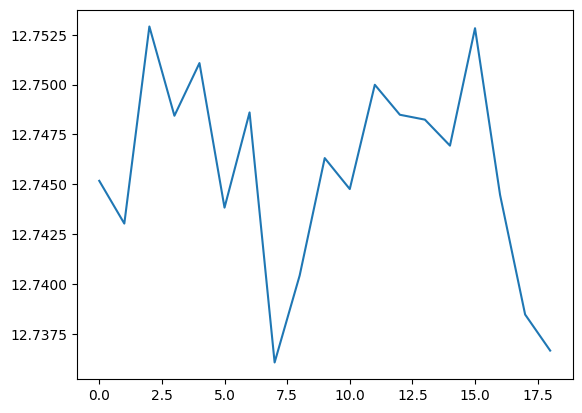

In [ ]:
plt.plot(loss_history)

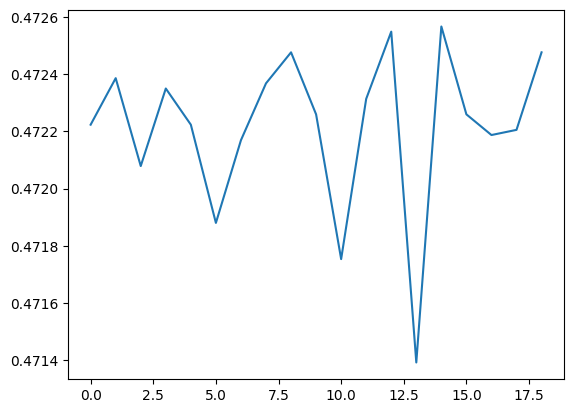

In [ ]:
plt.plot(train_acc_history)

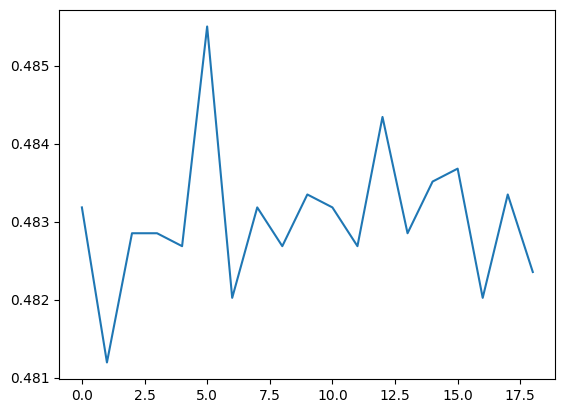

In [ ]:
plt.plot(test_acc_history)

In [ ]:
def is_state_dict_identical(state_dict1, state_dict2):
    return all([(state_dict1[key] == state_dict2[key]).all() for key in state_dict1])

In [ ]:
is_state_dict_identical(vision_encoder.state_dict(), torch.load('init_vision_encoder.pt'))

False

In [ ]:
is_state_dict_identical(image_emb_compressor.state_dict(), torch.load('init_image_emb_compressor.pt'))

False

In [ ]:
is_state_dict_identical(llm_model.state_dict(), torch.load('init_llm_model.pt'))

True